# PREPARE DATA

Load and concatenate dataframes from individual months

## Prepare

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

In [2]:
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [3]:
DROPNANS = True
INCIDENT = 'roubo_celular'

# TODO: inconsistencies found in temporal data
#BASE_COLS = ['DATAOCORRENCIA', 'HORAOCORRENCIA', 'PERIDOOCORRENCIA',]
# QUICKFIX: use first day of month as incident date
BASE_COLS = ['PERIDOOCORRENCIA']

# Neighborhood dataframe
COLS_HOOD = BASE_COLS + ['BAIRRO']

# Localizations dataframe
COLS_LOC = BASE_COLS + ['LATITUDE', 'LONGITUDE']

# Prints to check everything is ok
DEBUG_MODE = True

In [4]:
DIR_DATA_CRIMES = "../data/crimes"
PATH_CRIMES = f"{DIR_DATA_CRIMES}/{INCIDENT}"

DIR_DATA_GEO = "../data/malhas"
PATH_DISTRICT = f"{DIR_DATA_GEO}/SIRGAS_GPKG_distrito.gpkg"
PATH_HIDRO = f"{DIR_DATA_GEO}/SIRGAS_SHP_hidromassadagua_polygon.shp"
#PATH_HIDRO = f"{DIR_DATA_GEO}/SAD69-96_SHP_hidromassadagua_polygon.shp"

PATH_SUBWAY_LINE = f"{DIR_DATA_GEO}/SIRGAS_GPKG_linhametro.gpkg"
#PATH_SUBWAY_STATION = f"{DIR_DATA_GEO}/SIRGAS_GPKG_distrito.gpkg"
PATH_TRAIN_LINE = f"{DIR_DATA_GEO}/SIRGAS_GPKG_linhatrem.gpkg"
#PATH_TRAIN_STATION = f"{DIR_DATA_GEO}/SIRGAS_GPKG_distrito.gpkg"

In [5]:
if INCIDENT == 'roubo_celular':
    periods = [f'2023_{i:02d}' for i in range(1, 13)] + ['2024_01']
periods

['2023_01',
 '2023_02',
 '2023_03',
 '2023_04',
 '2023_05',
 '2023_06',
 '2023_07',
 '2023_08',
 '2023_09',
 '2023_10',
 '2023_11',
 '2023_12',
 '2024_01']

In [6]:
# just for reference,
dfx = pd.read_excel(f"{PATH_CRIMES}/2024_01.xlsx")

In [7]:
dfx.columns

Index(['ANO_BO', 'NUM_BO', 'NUMERO_BOLETIM', 'BO_INICIADO', 'BO_EMITIDO',
       'DATAOCORRENCIA', 'HORAOCORRENCIA', 'PERIDOOCORRENCIA',
       'DATACOMUNICACAO', 'DATAELABORACAO', 'BO_AUTORIA', 'FLAGRANTE',
       'NUMERO_BOLETIM_PRINCIPAL', 'LOGRADOURO', 'NUMERO', 'BAIRRO', 'CIDADE',
       'UF', 'LATITUDE', 'LONGITUDE', 'DESCRICAOLOCAL', 'EXAME', 'SOLUCAO',
       'DELEGACIA_NOME', 'DELEGACIA_CIRCUNSCRICAO', 'ESPECIE', 'RUBRICA',
       'DESDOBRAMENTO', 'STATUS', 'TIPOPESSOA', 'VITIMAFATAL', 'NATURALIDADE',
       'NACIONALIDADE', 'SEXO', 'DATANASCIMENTO', 'IDADE', 'ESTADOCIVIL',
       'PROFISSAO', 'GRAUINSTRUCAO', 'CORCUTIS', 'NATUREZAVINCULADA',
       'TIPOVINCULO', 'RELACIONAMENTO', 'PARENTESCO', 'PLACA_VEICULO',
       'UF_VEICULO', 'CIDADE_VEICULO', 'DESCR_COR_VEICULO',
       'DESCR_MARCA_VEICULO', 'ANO_FABRICACAO', 'ANO_MODELO',
       'DESCR_TIPO_VEICULO', 'QUANT_CELULAR', 'MARCA_CELULAR'],
      dtype='object')

In [8]:
df_hood = None
df_loc = None
for period in periods:
    df = pd.read_excel(f"{PATH_CRIMES}/{period}.xlsx")
    # filter capital
    df = df[df["CIDADE"] == "S.PAULO"]

    # standarize neighborhood
    df["BAIRRO"] = df["BAIRRO"].str.upper()

    ## TODO: inconsistencies found in temporal data
    #df['DATAOCORRENCIA'] = pd.to_datetime(df['DATAOCORRENCIA'], format='%d/%m/%Y')
    #if DEBUG_MODE:
    #    print(
    #        f"{period}\t{df['DATAOCORRENCIA'].min()}\t{df['DATAOCORRENCIA'].max()}"
    #    )
    # QUICKFIX: use first day of month as incident date
    year, month = [int(s) for s in period.split(sep='_')]
    df["period"] = period
    df["year"] = year
    df["month"] = month
    df["date"] = pd.Timestamp(year=year, month=month, day=1)
    COLS_DT = ["period", "year", "month", "date"]

    df_hood = pd.concat([df_hood, df[COLS_HOOD + COLS_DT]])
    df_loc = pd.concat([df_loc, df[COLS_LOC + COLS_DT]])

    print(f"Period {period} done")

Period 2023_01 done
Period 2023_02 done
Period 2023_03 done
Period 2023_04 done
Period 2023_05 done
Period 2023_06 done
Period 2023_07 done
Period 2023_08 done
Period 2023_09 done
Period 2023_10 done
Period 2023_11 done
Period 2023_12 done
Period 2024_01 done


Remove NaNs,

In [9]:
df_hood["BAIRRO"].value_counts()

BAIRRO
REPUBLICA               2970
CAPAO REDONDO           2967
PINHEIROS               2445
ITAIM BIBI              2369
CAMPO LIMPO             2160
                        ... 
JARDIM COTIANA             1
VILA ARAPUA                1
JARDIM MORADA DO SOL       1
PARQUE SAO LUCAS           1
CIDADE DE DEUS             1
Name: count, Length: 1772, dtype: int64

In [10]:
print(df_hood.shape, df_loc.shape)
df_hood = df_hood[df_hood["BAIRRO"].notna()]
df_loc = df_loc[(df_loc["LONGITUDE"].notna())]
df_loc = df_loc[(df_loc["LATITUDE"].notna())]
print(df_hood.shape, df_loc.shape)

(136917, 6) (136917, 7)
(136158, 6) (121930, 7)


In [11]:
df_hood.groupby("date")["period"].count()

date
2023-01-01     5921
2023-02-01     9319
2023-03-01    13717
2023-04-01    11185
2023-05-01    11574
2023-06-01    10622
2023-07-01    10528
2023-08-01    11155
2023-09-01    10686
2023-10-01    10926
2023-11-01    10521
2023-12-01    10533
2024-01-01     9471
Name: period, dtype: int64

In [12]:
df_loc.groupby("date")["period"].count()

date
2023-01-01     5298
2023-02-01     8413
2023-03-01    12070
2023-04-01     9923
2023-05-01    10315
2023-06-01     9615
2023-07-01     9637
2023-08-01     9996
2023-09-01     9700
2023-10-01     9809
2023-11-01     9427
2023-12-01     9336
2024-01-01     8391
Name: period, dtype: int64

## Problem with `df_hood`: too much granularity

Municipio -> Prefeituras Regionais -> Distritos -> Bairros

In [13]:
df_hood["BAIRRO"].value_counts()

BAIRRO
REPUBLICA               2970
CAPAO REDONDO           2967
PINHEIROS               2445
ITAIM BIBI              2369
CAMPO LIMPO             2160
                        ... 
JARDIM COTIANA             1
VILA ARAPUA                1
JARDIM MORADA DO SOL       1
PARQUE SAO LUCAS           1
CIDADE DE DEUS             1
Name: count, Length: 1772, dtype: int64

Solutions:
- Map "BAIRRO" column to new "DISTRITO" column (hard).
- Use `df_loc` to intersect (lat, lon) with available district areas.

# Continue with `df_loc`

Fix types in location columns,

In [14]:
df_loc.dtypes

PERIDOOCORRENCIA            object
LATITUDE                    object
LONGITUDE                  float64
period                      object
year                         int64
month                        int64
date                datetime64[us]
dtype: object

In [15]:
df_loc["LATITUDE"].map(type).value_counts()

LATITUDE
<class 'float'>    102319
<class 'int'>       19610
<class 'str'>           1
Name: count, dtype: int64

safe way: keep only floats,

TODO: maybe include ints

In [16]:
print(df_loc.shape)
df_loc = df_loc[df_loc["LATITUDE"].map(type) == float]
print(df_loc.shape)

(121930, 7)
(102319, 7)


In [17]:
df_loc["LATITUDE"] = df_loc["LATITUDE"].astype(float)

In [18]:
df_loc[["LONGITUDE", "LATITUDE"]].describe()

,LONGITUDE,LATITUDE
count,1.023190e+05,1.023190e+05
mean,-1.917928e+14,-1.017803e+14
std,2.282972e+14,1.161833e+14
min,-4.682100e+14,-2.391136e+14
25%,-4.662777e+14,-2.355412e+14
50%,-4.669636e+10,-2.364833e+10
75%,-4.669047e+08,-2.360323e+08
max,-4.644300e+04,-2.359700e+04


the orders of magnitudes of entries are absolutely absurd! solution:

## HARDFIX

123456789012345 -> 12.345...

In [19]:
import numpy as np

In [20]:
def fixlatlon(n) -> float:
    tenpow = np.ceil(np.log10(np.abs(float(n)))) - 2
    return n / (10**tenpow)

In [21]:
#np.log10(float(12345678.901234567))

In [22]:
#fixlatlon(-12345678.901234567)

In [23]:
df_loc["LATITUDE"] = df_loc["LATITUDE"].apply(fixlatlon)
df_loc["LONGITUDE"] = df_loc["LONGITUDE"].apply(fixlatlon)

In [24]:
df_loc[["LATITUDE", "LONGITUDE"]].describe()

,LATITUDE,LONGITUDE
count,102319.000000,102319.000000
mean,-23.577875,-46.624283
std,0.072770,0.107551
min,-23.938062,-46.855411
25%,-23.621361,-46.699740
50%,-23.565578,-46.644275
75%,-23.529952,-46.565603
max,-23.357000,-46.365850


Add geometry column,

In [25]:
df_loc["geometry"] = df_loc.apply(lambda x: Point(x["LONGITUDE"], x["LATITUDE"]), axis=1)

Create GeoDataFrame,

In [26]:
gdf_loc = gpd.GeoDataFrame(df_loc, geometry="geometry")

<Axes: >

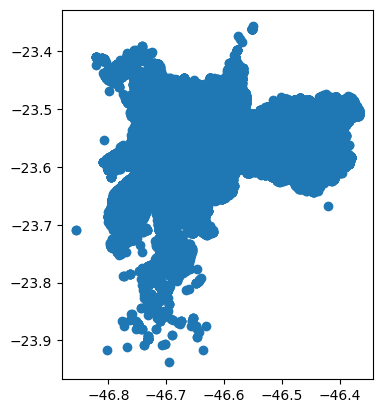

In [27]:
gdf_loc.plot()

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

Read Districts,

In [29]:
gdf_distr = gpd.read_file(PATH_DISTRICT)

In [30]:
layers = gpd.list_layers(PATH_DISTRICT)
print(layers)

                   name geometry_type
0  SIRGAS_GPKG_distrito       Unknown


In [31]:
gdf_distr.crs

<Projected CRS: EPSG:31983>
Name: SIRGAS 2000 / UTM zone 23S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - between 48°W and 42°W, northern and southern hemispheres, onshore and offshore.
- bounds: (-48.0, -33.5, -42.0, 5.13)
Coordinate Operation:
- name: UTM zone 23S
- method: Transverse Mercator
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [32]:
#gdf_distr.set_crs(epsg=4674)
gdf_distr = gdf_distr.to_crs(crs="EPSG:4674")

In [33]:
gdf_hidro = gpd.read_file(PATH_HIDRO)
gdf_hidro = gdf_hidro.set_crs("EPSG:31983").to_crs("EPSG:4674")  # use gdf_distr.crs


In [34]:
gdf_subway_line = gpd.read_file(PATH_SUBWAY_LINE)
gdf_subway_line = gdf_subway_line.to_crs("EPSG:4674")

gdf_train_line = gpd.read_file(PATH_TRAIN_LINE)
gdf_train_line = gdf_train_line.to_crs("EPSG:4674")

<Axes: xlabel='LONGITUDE', ylabel='LATITUDE'>

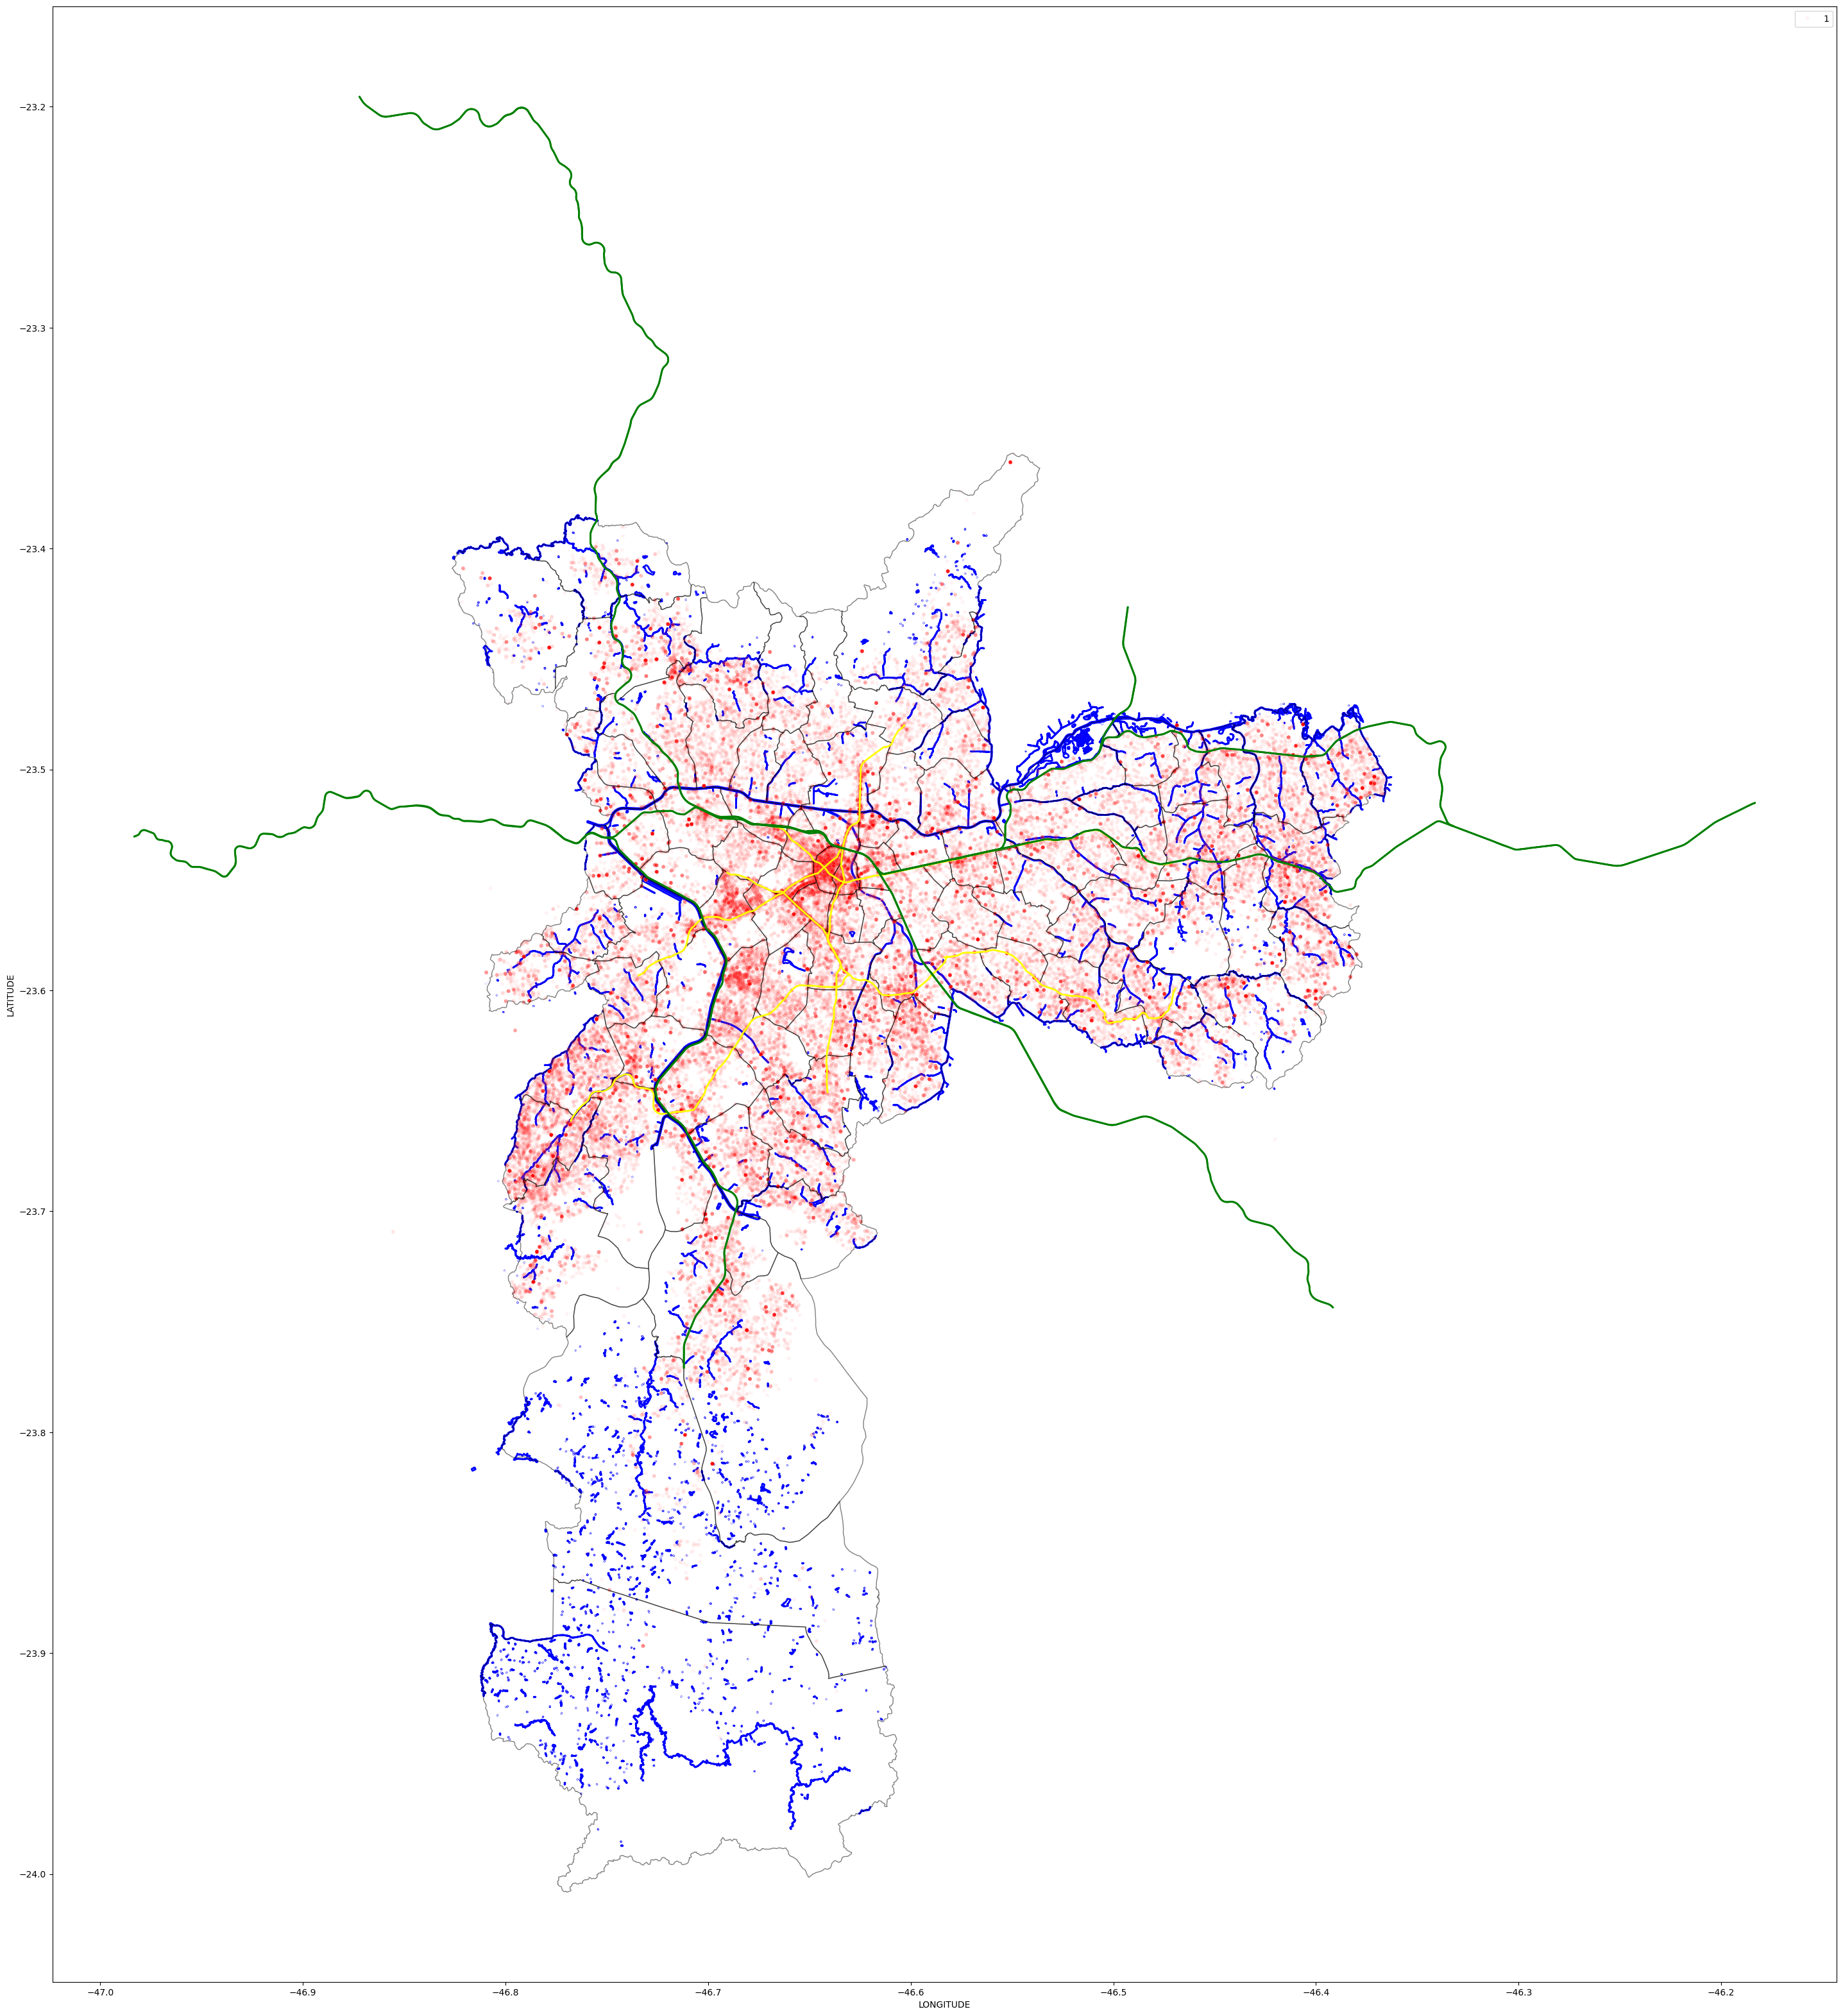

In [35]:
fig, ax = plt.subplots(figsize=(40, 40))
gdf_hidro.plot(ax=ax, facecolor="None", edgecolor="blue", linewidth=2)
sns.scatterplot(data=gdf_loc, x="LONGITUDE", y="LATITUDE", ax=ax, alpha=0.05, size=1, color="red")
gdf_distr.plot(ax=ax, facecolor="None", edgecolor="black", alpha=0.5, linewidth=1)
gdf_subway_line.plot(ax=ax, facecolor="None", edgecolor="yellow", alpha=1, linewidth=2)
gdf_train_line.plot(ax=ax, facecolor="None", edgecolor="green", alpha=1, linewidth=2)

In [ ]:
def plot_subway_lines(gdf, alpha, linewidth):
    dict_colors = {
        "AZUL": "#000088",
    }

In [ ]:
gdf_subway_line

,lmt_nome,lmt_linom,lmt_empres,lmt_linha,geometry
0,AZUL,LINHA 1 - AZUL,METRO,1,"LINESTRING (-46.60291 -23.47973, -46.60402 -23..."
1,VERDE,LINHA 2 - VERDE,METRO,2,"LINESTRING (-46.69089 -23.54643, -46.69022 -23..."
2,VERMELHA,LINHA 3 - VERMELHA,METRO,3,"LINESTRING (-46.66754 -23.52593, -46.66669 -23..."
3,LILAS,LINHA 5 - LILÁS,METRO,5,"LINESTRING (-46.63049 -23.59263, -46.63077 -23..."
4,PRATA,LINHA 15 - PRATA,METRO,15,"LINESTRING (-46.5838 -23.58475, -46.58351 -23...."
5,AMARELA,LINHA 4 - AMARELA,VIAQUATRO,4,"LINESTRING (-46.63449 -23.53615, -46.63495 -23..."
